# Clase 5: Métodos Basados en Árboles 
### Diplomado en Data Science UC 2022

---

La clase anterior aprendimos las principales funciones de preprocesamiento y nuestros primeros modelos de Machine Learning del curso. En la sección de ejercicios vimos como aplicar el procesamiento separando los sets en variables numéricas y categóricas. A pesar de que cumplimos el propósito de aplicar los preprocesamientos a las variables correctas (o sea según su tipo), no es la forma más simple de hacerlo porque Scikit-Learn nos provee de funcionalidades más automatizadas.

Antes de introducirnos de lleno en **métodos basados en árboles**, veamos como implementar **pipelines y transformers**.

## Column Transformers

<img src="https://amueller.github.io/aml/_images/column_transformer_schematic.png" style="background: white; width: 1000px"/>

Uno de los primeros aspectos a considerar al momento de entrenar modelos de Machine Learning, es que las variables estén en un formato correcto para estos algoritmos. Carguemos la base de datos `tips`  a modo de ejemplo, donde intersa predecir la variable `tip` de acuerdo al resto de predictores:

In [1]:
import pandas as pd

tips = pd.read_csv("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/tips.csv")
print("Primeras filas:")
display(tips.head())
print("Información sobre variables:\n")
tips.info()

Primeras filas:


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Información sobre variables:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


Nos gustaría crear variables *dummy* para las variables categóricas, o sea `sex`, `smoker`, `day` y `time`. Para las variables numéricas, un buen punto de partida es estandarizarlas. Notar que el tipo de preprocesamiento varía en función del modelo a utilizar.

Antes, separemos la base de datos en set de entrenamiento y testeo:

In [2]:
X = tips.drop(columns="tip")
y = tips["tip"]

print("Predictores       :", X.columns.to_list())
print("Variable respuesta:", y.name)

Predictores       : ['total_bill', 'sex', 'smoker', 'day', 'time', 'size']
Variable respuesta: tip


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

X_train.head()

,total_bill,sex,smoker,day,time,size
181,23.33,Male,Yes,Sun,Dinner,2
17,16.29,Male,No,Sun,Dinner,3
65,20.08,Male,No,Sat,Dinner,3
73,25.28,Female,Yes,Sat,Dinner,2
136,10.33,Female,No,Thur,Lunch,2


El proceso de dummificar variables categóricas y normalizar variables numéricas lo podemos llevar a cabo con la función `make_column_transformer` del módulo `compose` de `sklearn`, donde le especificamos a que columnas queremos realizar cada transformación.

In [4]:
variables_categoricas = X_train.columns[X_train.dtypes == "object"].to_list()
variables_numericas   = X_train.columns[X_train.dtypes != "object"].to_list()
print("Variables categóricas:", variables_categoricas)
print("Variables numéricas  :", variables_numericas)

Variables categóricas: ['sex', 'smoker', 'day', 'time']
Variables numéricas  : ['total_bill', 'size']


Ahora si, apliquemos el transformer a nuestro set de datos de entrenamiento y testeo:

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Primero instanciamos las clases
one_hot = OneHotEncoder(drop="first", sparse=False)
scaler  = StandardScaler()
# Creamos transformer
transformer = make_column_transformer(
    (one_hot, variables_categoricas),          # Preprocesamiento para variables categóricas
    (scaler,  variables_numericas),            # Preprocesamiento para variables numéricas
    remainder                 = "passthrough", # Cuando no preprocesamos todas las variables
    verbose_feature_names_out = False          # Para no agregar el tipo de prep. a las variables
)
# Aprendemos sobre el set de entrenamiento
transformer.fit(X_train)
# Aplicamos cambios a set de entrenamiento y testeo
X_train_prep = pd.DataFrame(transformer.transform(X_train), columns=transformer.get_feature_names_out())
X_test_prep  = pd.DataFrame(transformer.transform(X_test),  columns=transformer.get_feature_names_out())
# Resultados:
print("Set de entrenamiento preprocesado:")
display(X_train_prep.head())
print("Set de testeo preprocesado:")
display(X_test_prep.head())

Set de entrenamiento preprocesado:


,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch,total_bill,size
0,1.0,1.0,0.0,1.0,0.0,0.0,0.390895,-0.607351
1,1.0,0.0,0.0,1.0,0.0,0.0,-0.419001,0.440733
2,1.0,0.0,1.0,0.0,0.0,0.0,0.017009,0.440733
3,0.0,1.0,1.0,0.0,0.0,0.0,0.615227,-0.607351
4,0.0,0.0,0.0,0.0,1.0,1.0,-1.104651,-0.607351


Set de testeo preprocesado:


,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch,total_bill,size
0,1.0,0.0,0.0,1.0,0.0,0.0,-0.704305,-0.607351
1,1.0,1.0,0.0,0.0,1.0,1.0,-0.738817,-0.607351
2,0.0,1.0,1.0,0.0,0.0,0.0,0.833806,-0.607351
3,1.0,1.0,1.0,0.0,0.0,0.0,0.314967,-0.607351
4,0.0,0.0,1.0,0.0,0.0,0.0,0.745224,-0.607351


Recordemos que debemos utilizar nuestros datos de testeo de forma **ciega**, por ello no aplicamos el método `fit` de igual forma al set de testeo. ¡Los datos están listos para entrenar! Ajustemos una *Regresión Lineal* a estos datos:

In [6]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train_prep, y_train)
print("R^2:", regressor.score(X_test_prep, y_test))

R^2: 0.43506189304350573


## Pipelines

<img src="https://onnx.ai/sklearn-onnx/_images/blockdiag-0e2bbe287bfc020181cb7981832f234c906f12a6.png" style="background: white; width: 500px"/>

Ir paso a paso aplicando transformaciones a nuestros datos puede ser tedioso, en especial si el modelo a utilizar considera muchas etapas de preprocesamiento. Para estos casos podemos usar un **pipeline**, que va aplicando transformaciones secuencialmente y ajusta un modelo final, en caso de que así se lo indiquemos.

Para usar un pipeline, usamos la función `make_pipeline` del módulo `pipeline` de `sklearn`.

In [7]:
from sklearn.pipeline import make_pipeline

# Creamos pipeline
pipeline = make_pipeline(
    transformer, # Etapa 1: Preprocesamiento según variable
    regressor    # Etapa 2: Modelamiento
)
# Ajustamos pipeline
pipeline.fit(X_train, y_train)
# Comprobamos métrica en testeo
print("R^2:", pipeline.score(X_test, y_test))

R^2: 0.43506189304350573


Finalmente, tenemos un pipeline que automáticamente realiza el preprocesamiento de datos y ajusta el modelo que le indicamos. 

Podemos añadir la cantidad de etapas de preprocesamiento que estimemos conveniente. Tradicionalmente los pipelines consideran etapas de:

* Imputación de datos faltantes.
* Estandarización o normalización.
* Codificación de variables o dummies.
* Reducción de dimensionalidad (lo veremos en clases siguientes).
* Modelamiento.

A continuación veamos un ejemplo más complejo que involucre estas etapas:

In [8]:
import numpy as np
# Creamos datos faltantes para probar la herramiento a usar
X_train.iloc[:5, [0, 2]] = np.nan
X_test.iloc [:5, [0, 2]] = np.nan

X_train.isna().sum()

total_bill    5
sex           0
smoker        5
day           0
time          0
size          0
dtype: int64

Acabamos de agregar 10 datos faltantes a el set de entrenamiento y testeo.

In [9]:
# Para ver diagrama al ajustar modelos.
import sklearn
sklearn.set_config(display="diagram")

# Importamos las clases a usar e instanciamos
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

numeric_imputer     = IterativeImputer(DecisionTreeRegressor(random_state=2022))
categorical_imputer = SimpleImputer(strategy="most_frequent")
dimension_reduction = PCA(n_components=1)
poly_vars           = PolynomialFeatures()

# Definimos preprocesamiento según tipo de datos
numeric_prep = make_pipeline(
    numeric_imputer,    # Etapa 1: Imputar datos faltantes
    scaler,             # Etapa 2: Estandarizar datos
    dimension_reduction # Etapa 3: Reducción de dimensionalidad
)
categorical_prep = make_pipeline(
    categorical_imputer,  # Etapa 1: Imputar datos faltantes
    one_hot               # Etapa 2: Variables dummy
)
# Unimos ambos preprocesamientos en un transformer
transformer = make_column_transformer(
    (numeric_prep, variables_numericas),
    (categorical_prep, variables_categoricas),
    remainder                 = "passthrough",
    verbose_feature_names_out = False
)
# Definimos el modelo final
model = SVR() # Support Vector Regression
# Creamos pipeline que involucra todas estas etapas
pipeline = make_pipeline(
    transformer, # Etapa 1: Preprocesamiento según tipo de variable
    poly_vars,   # Etapa 2: Crear variables polinomicas con variables resultantes
    model        # Etapa 3: Modelamiento con un Support Vector Machine
)
# Ajustamos todo el pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer(estimator=DecisionTreeRegressor(random_state=2022))),
                                                                  ('standardscaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=1))]),
                                                  ['total_bill', 'size']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])],
                                   verbose_feature_names_out=False)),
                ('polynomialfeatures', PolynomialFeatures()), ('svr', SVR())])

Ahora tenemos un proceso que considera más etapas y se encuentra automatizado. Finalmente veamos los resultados en el set de testeo:

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = pipeline.predict(X_test)
print("Resultados:")
print("- R^2 :", pipeline.score(X_test, y_test))
print("- RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("- MAE :", mean_absolute_error(y_test, y_pred))

Resultados:
- R^2 : 0.5681939495010921
- RMSE: 0.8727387087068474
- MAE : 0.6601604989298456


## Árboles de decisión

Los árboles de decisión son algoritmos versátiles y potentes. 
- Se pueden utilizar para problemas de clasificación, regresión u otros.
- No requiere escalar las variables de ingreso.
- Alta interpretabilidad.
- Forman la base del algoritmo Random Forest que veremos hoy.

Los árboles de decisión están dentro del módulo `tree` de `sklearn` y las clases disponibles son `DecisionTreeRegressor` y `DecisionTreeClassifier` de acuerdo a si nuestro problema es de clasificación o regresión.

Obtengamos data de ejemplo para estudiar funcionamiento del algoritmo.

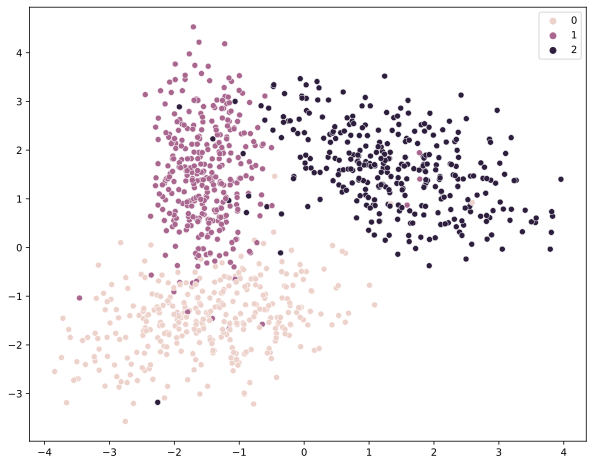

In [11]:
from sklearn.datasets import make_classification
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "svg"
plt.rcParams["figure.figsize"] = (10, 8)

X, y = make_classification(
    n_samples            = 1000,
    n_classes            = 3,
    n_features           = 2,
    n_informative        = 2,
    n_redundant          = 0,
    class_sep            = 1.5,
    n_clusters_per_class = 1,
    random_state         = 1007
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

Como es habitual, separemos nuestros datos en sets de entrenamiento y testeo.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)

Ahora ajustemos el *Árbol de Clasificación*, como el problema es de clasificación, usamos la clase `DecisionTreeClassifier`:

In [13]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier(random_state=2022, criterion="entropy")
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=2022)

¿Pero qué hacen los Árboles de decisión en la práctica? La respuesta es que paso a paso van buscando secciones en los datos que sean cada vez más puras, o sea secciones en que los datos pertenezcan mayoritariamente a una sola categoría.

Veamos el mismo gráfico de antes pero con las secciones de clasificacion creadas por el modelo incluídas.

Accuracy: 0.92


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


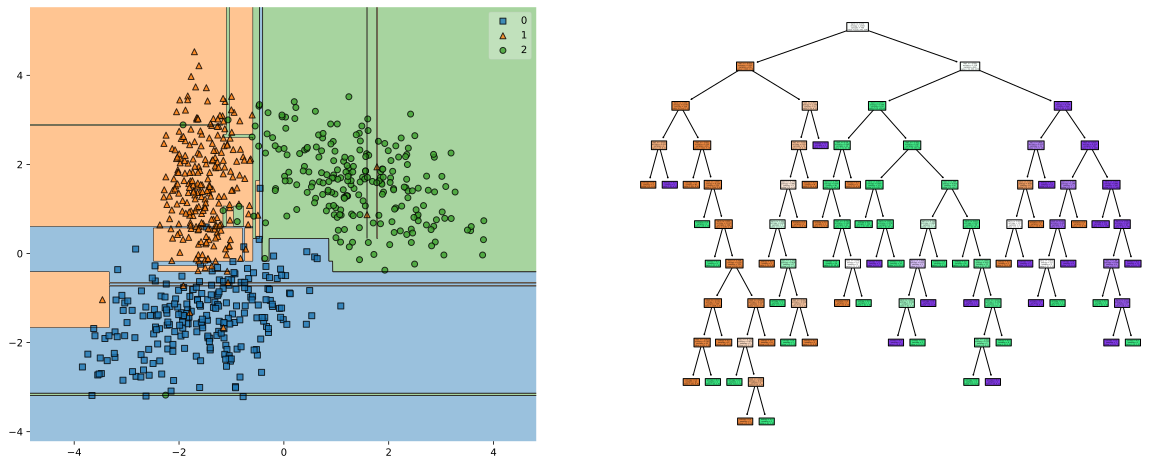

In [14]:
# !pip install mlxtend
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import plot_tree

print("Accuracy:", dec_tree.score(X_test, y_test))
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
plot_decision_regions(X_train, y_train, dec_tree, ax=ax[0])
plot_tree(dec_tree, feature_names=["Var1", "Var2"], filled=True, ax=ax[1]);

En este caso, vemos secciones que básicamente son una linea recta y eso significa que involucran datos con información muy específica, ya que no establecimos un límite de profundidad de nuesto árbol. Esto no es la idea, pues necesitamos secciones que favorezcan la capacidad de generalización para mejorar la performance con datos no observados. 

Para solucionar la problemática anterior podemos ajustar una gran variedad de hiperparámetros, pero los que más generan impacto son los siguientes:

* `max_depth`: Indica la profundidad del árbol, debe ser un número entero. Valores bajos favorecen la capacidad de generalización.
* `ccp_alpha`: Cost Complexity Pruning, debe ser un número positivo. Es un hiperparámetro de postprocesamiento. Penaliza la cantidad de nodos terminales, favoreciendo los árboles con menor cantidad de estos.

Ambos parámetros se pueden ajustar mediante técnicas de busqueda de hiperparámetros con validación cruzada (ver clase 4). Una buena técnica es considerar un árbol muy profundo y ajustar solamente el parámetro `ccp_alpha`. Veamos esto en la práctica:

In [15]:
from sklearn.model_selection import GridSearchCV, KFold

hiperparametros = {"ccp_alpha": np.logspace(-4, 1, 15)}
configuraciones = KFold(n_splits=10, shuffle=True, random_state=2022)
modelo          = DecisionTreeClassifier(max_depth=30, criterion="entropy", random_state=2022)

modelos = GridSearchCV(
    estimator  = modelo,          
    param_grid = hiperparametros, 
    cv         = configuraciones, 
    scoring    = "accuracy",      
    n_jobs     = -1,              
    verbose    = 1                
)
modelos.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=2022, shuffle=True),
             estimator=DecisionTreeClassifier(criterion='entropy', max_depth=30,
                                              random_state=2022),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([1.00000000e-04, 2.27584593e-04, 5.17947468e-04, 1.17876863e-03,
       2.68269580e-03, 6.10540230e-03, 1.38949549e-02, 3.16227766e-02,
       7.19685673e-02, 1.63789371e-01, 3.72759372e-01, 8.48342898e-01,
       1.93069773e+00, 4.39397056e+00, 1.00000000e+01])},
             scoring='accuracy', verbose=1)

Veamos los resultados de la validación cruzada para cada valor de `ccp_alpha`.

In [16]:
tabla_resultados = pd.DataFrame(modelos.cv_results_)[["param_ccp_alpha", "mean_test_score"]]
tabla_resultados.sort_values("mean_test_score", ascending=False).style.bar("mean_test_score")

,param_ccp_alpha,mean_test_score
7,0.031623,0.951429
8,0.071969,0.951429
9,0.163789,0.951429
10,0.372759,0.951429
6,0.013895,0.945714
5,0.006105,0.927143
0,0.000100,0.921429
1,0.000228,0.921429
2,0.000518,0.921429
3,0.001179,0.921429


El mejor valor para `ccp_alpha` es 0.031623 siguiendo la estrategia de validación cruzada alcanzando un `accuracy` $\approx$ 0.951. Ahora veamos el comportamiento del `accuracy` con distintos valores para este hiperparámetro.

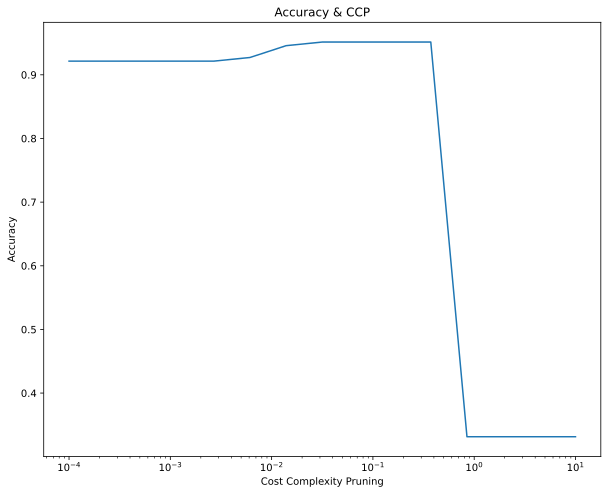

In [17]:
sns.lineplot(data=tabla_resultados, x="param_ccp_alpha", y="mean_test_score")
plt.xscale("log")
plt.title("Accuracy & CCP")
plt.xlabel("Cost Complexity Pruning")
plt.ylabel("Accuracy");

O sea que se están favoreciendo valores relativamente bajos de penalización por cantidad de nodos terminales. Ajustemos el mejor modelo y comparemos con las gráficas anteriores.

In [18]:
best_tree = modelos.best_estimator_.fit(X_train, y_train)

Accuracy: 0.9366666666666666


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


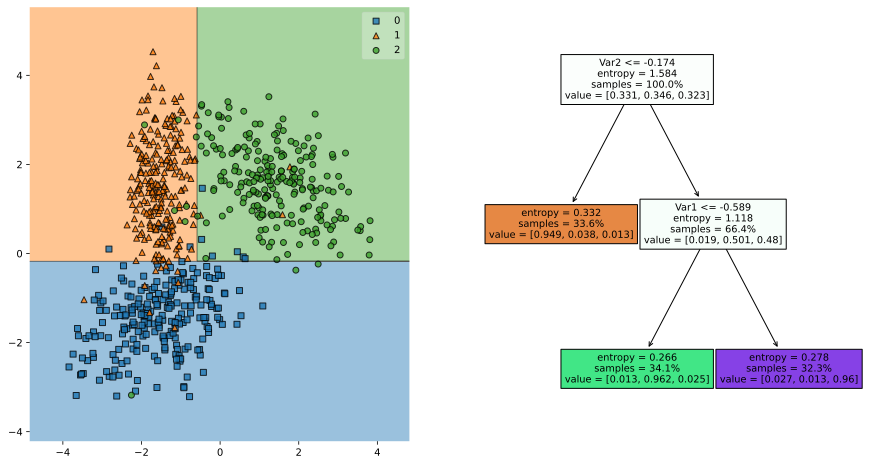

In [19]:
print("Accuracy:", best_tree.score(X_test, y_test))

fig, ax = plt.subplots(ncols=2, figsize=(15, 8))
plot_decision_regions(X_train, y_train, best_tree, ax=ax[0])
plot_tree(
    decision_tree = best_tree,
    proportion    = True,
    feature_names = ["Var1", "Var2"],
    filled        = True,
    ax            = ax[1]
);

Ahora tenemos regiones de clasificación mucho más definidas y por ende, mejor capacidad de generalización. Esto se refleja en un árbol de clasificación más simple que en las gráficas anteriores.

## Random Forest

Acabamos de ajustar un árbol de decisión optimo para nuestros datos `tips`. Sin embargo, el árbol de decisión es un estimador que sufre de alta varianza, es decir, en promedio las predicciones son correctas, pero se encuentran lejos del valor esperado. La siguiente imagen intenta explicar el fenómeno descrito.

<img src="https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fjason-chen-1992.weebly.com%2Fuploads%2F1%2F0%2F8%2F5%2F108557741%2Fbias-and-variance_orig.png&f=1&nofb=1" style="background: white; width: 500px"/>

La solución a este problema consiste entrenar muchos árboles de decisión a través de la estrategia **bootstrap**, esta consiste en crear $B$ muestras con las mismas observaciones con con repetición sobre filas y columnas, luego para cada muestra se ajusta un árbol de decisión con la característica de ser un **weak learner**. La clasificación que puedan hacer muchos **weak learners** suele ser mucho más robusta que uno solo. Esta idea se describe como **Random Forest**, que es un método de ensamblado, o sea, que realiza predicciones en base a muchos árboles de decisión entrenados **por separado**.

<img src="https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2F1.cms.s81c.com%2Fsites%2Fdefault%2Ffiles%2F2020-12-07%2FRandom%2520Forest%2520Diagram.jpg&f=1&nofb=1" style="background: white; width: 500px"/>



Para obtener la clasificación final, se obtiene la **media** de las predicciones como podemos ver en la siguiente fórmula.

$$
f(X) = {f_1(X) + f_2(X) + \dots + f_N(X) \over N} + \epsilon
$$


Veamos como implementarlo con Scikit-Learn.

Accuracy: 0.94


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


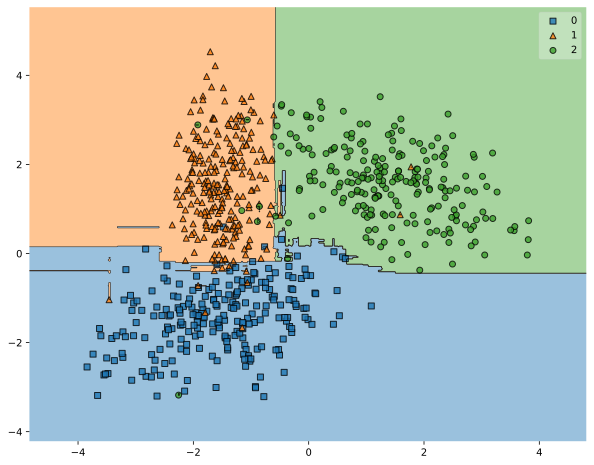

In [20]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(random_state=2022)
modelo_rf.fit(X_train, y_train)
print("Accuracy:", modelo_rf.score(X_test, y_test))
plot_decision_regions(X_train, y_train, modelo_rf);

Con esté método de clasificación, notamos fronteras mucho más suaves y adaptadas a nuestros datos. Conozcamos algunos hiperparámetros disponibles para mejorar la capacidad de generalización de este modelo.

* `n_estimators`: Cantidad de árboles a entrenar.
* `max_depth`: Profundidad máxima de cada árbol.
* `ccp_alpha`: Cost Complexity Pruning. Parámetro que penaliza árboles con muchos nodos terminales, favoreciendo la generalización.

Al igual que con un árbol de decisión, podemos establecer un valor de `max_depth` alto para permitir el cre y buscar con validación cruzada los mejores valores para `n_estimators` y `ccp_alpha`.

In [21]:
from sklearn.model_selection import GridSearchCV, KFold

hiperparametros = {
    "n_estimators": np.arange(10, 151, 15),
    "ccp_alpha"   : np.logspace(-4, 0.5, 10)
}
configuraciones = KFold(n_splits=5, shuffle=True, random_state=2022)
modelo          = RandomForestClassifier(max_depth=30, criterion="entropy", random_state=2022)

modelos = GridSearchCV(
    estimator  = modelo,          
    param_grid = hiperparametros, 
    cv         = configuraciones, 
    scoring    = "accuracy",      
    n_jobs     = -1,              
    verbose    = 1                
)
modelos.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=2022, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy', max_depth=30,
                                              random_state=2022),
             n_jobs=-1,
             param_grid={'ccp_alpha': array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00]),
                         'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100, 115, 130, 145])},
             scoring='accuracy', verbose=1)

Veamos el mejor modelo que resultó del proceso de ajuste de hiperparámetros con validación cruzada:

Mejores hiperparámetros: {'ccp_alpha': 0.01, 'n_estimators': 70}
Accuracy: 0.94


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


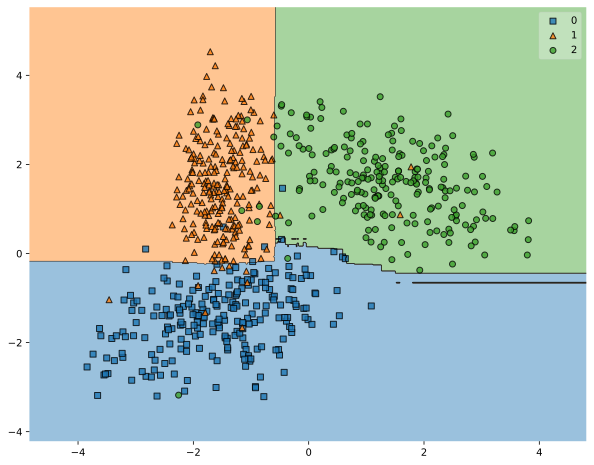

In [22]:
print("Mejores hiperparámetros:", modelos.best_params_)
best_rf = modelos.best_estimator_.fit(X_train, y_train)

print("Accuracy:", best_rf.score(X_test, y_test))
plot_decision_regions(X_train, y_train, best_rf);

Si bien los cambios no son tan drásticos al ajustar hiperparámetros, vemos frontereas más suaves respecto a la gráfica anterior, lo que se traduce en un mejor comportamiento con datos de testeo.

Una ventaja añadida a este modelo, es que podemos ver la importancia de cada variable. A través de la suma de la entropía que producen las variables en cada árbol, se puede calcular esta importancia, valores bajos nos indican que determinada variable produce secciones más puras a nivel global y por ende, es más importante. Scikit-Learn nos muestra la importancia relativa, o sea, que tan importante es cada variable respecto al resto.

In [23]:
pd.DataFrame(
    data    = zip(["Var1", "Var2"], best_rf.feature_importances_),
    columns = ["Variable", "Importancia Relativa"]
)\
    .sort_values("Importancia Relativa", ascending=False)\
    .style.bar()
    

,Variable,Importancia Relativa
1,Var2,0.513611
0,Var1,0.486389


En este caso podemos concluir que la variable 1 fue casi igual de importante que la variable 2.

## Boosted Trees 

Una variación sobre los métodos de **ensamblado**, como es **Random Forest**, son los métodos de **gradient boosting** basados en árboles.

<img src="https://rohitgr7.github.io/content/images/2019/03/Screenshot-from-2019-03-27-23-08-07-1.png" style="background: white; width: 1000px"/>

Podemos entenderlo como un algoritmo recursivo que incialmente entrena un árbol de decisión para el set de datos, y luego crea secuencialmente modelos sobre los residuos que genera el modelo incial. Está técnica es una de las más usadas actualmente y gracias a ella distintas personas han ganado competencias de Machine Learning en Kaggle.

Las librerías de python más populares para hacer este tipo de modelos son las siguientes:

* `sklearn`: usando las clases `GradientBoostingClassifier` o `GradientBoostingClassifier` del módulo `ensemble`.
* `xgboost`: eXtreme Gradient Boosting.
* `lightgbm` e `interpret`: desarrolladas por *Microsoft*. Considerán más rapidez e interpretabilidad respectivamente.
* `catboost`: Especializada en datos categóricos.



A continuación, aprendamos como implementarlo con la librería `xgboost`, esta es 100% compatible con `sklearn`.

Accuracy: 0.9533333333333334


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


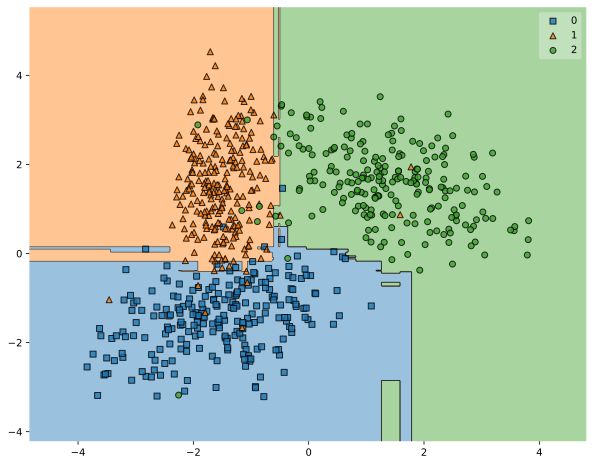

In [24]:
# !pip install xgboost
import xgboost as xg
modelo_gb = xg.XGBClassifier(eval_metric="mlogloss", use_label_encoder=False, random_state=2022, verbosity=0)
modelo_gb.fit(X_train, y_train)

print("Accuracy:", modelo_gb.score(X_test, y_test))
plot_decision_regions(X_train, y_train, modelo_gb);

Es posible mejorar su desempeño con datos no observados realizando búsqueda de los siguientes hiperparámetros:

* `n_estimator`: Cantidad de árboles secuenciales a realizar.
* `max_depth`: Profundidad máxima de cada árbol.
* `learning_rate`: Tasa de aprendizaje. Se define el porcentaje de aprendizaje que se obtendrá de cada árbol. Tasas altas significan aprendizaje más rápido pero inestable. Tasas bajas significan aprendizaje más lento pero estable.
* `gamma`: Penalización por tener árboles más profundos pero con poca ganancia de información respecto a menos profundos. Valores altos significan más penalización.

Llevemos esto a la práctica:

In [25]:
from sklearn.model_selection import GridSearchCV, KFold

hiperparametros = {
    "n_estimators" : np.arange(10, 101, 20),
    "gamma"        : np.logspace(-1, 1, 4),
    "learning_rate": np.linspace(0.1, 1.5, 7)
}
configuraciones = KFold(n_splits=3, shuffle=True, random_state=2022)
modelo          = xg.XGBClassifier(
    max_depth         = 10,
    eval_metric       = "mlogloss",
    use_label_encoder = False,
    random_state      = 2022,
    verbosity         = 0
)

modelos = GridSearchCV(
    estimator  = modelo,          
    param_grid = hiperparametros, 
    cv         = configuraciones, 
    scoring    = "accuracy",      
    n_jobs     = -1,              
    verbose    = 1                
)
modelos.fit(X_train, y_train)

Fitting 3 folds for each of 140 candidates, totalling 420 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=2022, shuffle=True),
             estimator=XGBClassifier(eval_metric='mlogloss', max_depth=10,
                                     random_state=2022, use_label_encoder=False,
                                     verbosity=0),
             n_jobs=-1,
             param_grid={'gamma': array([ 0.1       ,  0.46415888,  2.15443469, 10.        ]),
                         'learning_rate': array([0.1       , 0.33333333, 0.56666667, 0.8       , 1.03333333,
       1.26666667, 1.5       ]),
                         'n_estimators': array([10, 30, 50, 70, 90])},
             scoring='accuracy', verbose=1)

Mejores hiperparámetros: {'gamma': 2.1544346900318834, 'learning_rate': 1.0333333333333332, 'n_estimators': 10}
Accuracy: 0.9533333333333334


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


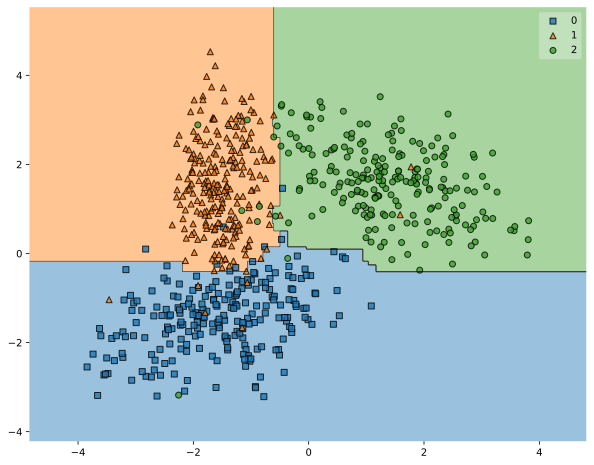

In [26]:
print("Mejores hiperparámetros:", modelos.best_params_)
best_gb = modelos.best_estimator_.fit(X_train, y_train)

print("Accuracy:", best_gb.score(X_test, y_test))
plot_decision_regions(X_train, y_train, best_gb);

Efectivamente se puede hacer una búsqueda más exhaustiva de hiperparámetros para obtener mejores resultados en el set de testeo. Para termiar, también podemos ver la importancia de cada variable. 

In [27]:
pd.DataFrame(
    data    = zip(["Var1", "Var2"], best_gb.feature_importances_),
    columns = ["Variable", "Importancia Relativa"]
)\
    .sort_values("Importancia Relativa", ascending=False)\
    .style.bar()

,Variable,Importancia Relativa
1,Var2,0.510907
0,Var1,0.489093


## Ejercicios de práctica

Es sabido que, una entidad que presta servicios o productos (pudiera ser una empresa, un banco, una tienda, etcétera) puede mejorar la experiencia de cliente desarrollando productos personalizados en pos de las preferencias y necesidades de cada uno de sus clientes.


El set de datos __potencial__ contiene datos sobre clientes de una institución financiera:

- **Customer ID**: ID asociado al cliente.
- **Age**: Edad en años del cliente.
- **Income**: Ingreso anual del cliente.
- **Family**: Tamaño del grupo familiar del cliente.
- **CCAvg**: Cupo promedio mensual utilizado en tarjetas de crédito.
- **Education**: Nivel educacional (1 si no es graduado, 2 graduado y 3 si posee estudios especializadoss (magister, doctorado, etcétera).
- **Mortgage**: Monto de la hipoteca (0 indica que no posee)
- **ZIP Code**: Código postal del domicilio.


En la última campaña a cada cliente se le ofreció un producto personalizado en base a su comportamiento financiero, preferencias, capacidad de pago y necesidades. La variable target corresponde a **Personal Loan** la cuál indica si el cliente tomó o no tomó este producto (¿El cliente aceptó o no el producto ofrecido? ), donde 0 indica que el cliente no adquirió el producto y 1 indica que sí lo adquirió.

Es de interés analizar cuáles pudieran ser los perfiles de clientes que tienen mayor probabilidad de aceptar el producto ofrecido, de manera de, identificar a los clientes con dichas características y priorizarlos a ellos en las próximas campañas.

**1.** Cargue la base de datos `potencial.xlsx` usando el bloque de código adjunto. Elimine las variables `ID` y `ZIP Code`, pues no es razonable obtener aprendizaje desde estas variables. Finalmente indique la cantidad de datos faltantes por variable a través de un gráfico de barras.

In [28]:
import pandas as pd

data = pd.read_excel("https://raw.githubusercontent.com/DiegoHoliwis/Diplomado_DS/main/Bases_Python/potencial.xlsx")
data.head()

,ID,Age,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan
0,1,25.0,49.0,91107,4,1.6,Undergraduate,0,0
1,2,45.0,34.0,90089,3,1.5,Undergraduate,0,0
2,3,39.0,11.0,94720,1,1.0,Undergraduate,0,0
3,4,35.0,100.0,94112,1,2.7,Graduate,0,0
4,5,35.0,45.0,91330,4,1.0,Graduate,0,0


In [29]:
# Responda aquí:


**2.** Muestre cuantos datos hay por cada etiqueta de la variable respuesta ¿Qué aspectos destacan?

In [30]:
# Responda aquí:


**2.** Separe aleatoriamente sus datos en 70% de entrenamiento y el resto para testeo.

In [31]:
# Responda aquí:


**3.** Indique el tipo de variable de sus predictores. Cree la lista `cat_vars` con el nombre de sus variables categóricas.

In [32]:
# Responda aquí:


**4.** Instancie las clases `OneHotEncoder` e `IterativeImputer` sin entregarle argumentos.

In [33]:
# Responda aquí:


**5.** Cree un transformer que realize variables dummy con las variables categóricas e impute los datos faltantes de las variables numéricas. Específicamente esto último puede llevarlo a cabo entregando la instancia para imputar datos del ejercicio anterior al parámetro `remainder`.

In [34]:
# Responda aquí:


**6.** Instancie las clases `DecisionTreeClassifier` y `RandomForestClassifier` desde los módulos `tree` y `ensemble` de `sklearn` respectivamente. En ambos modelos indique los siguientes parámetros:
* `max_depth=10`: Para que los árboles tengan profundidad máxima de 10.
* `criterion="entropy"`: Para usar entropía como criterio.
* `class_weight="balanced"`: Para ponderar cada observación. Es una forma de lidiar con el desbalanceo de datos, ya que asigna mayor peso a las categorías de la variable respuesta con menor volumen de datos.
* `random_state=2022`: Para reproducibilidad.


Finalmente cree pipelines que consideren el transformer creado en el ejercicio anterior y cada uno de estos modelos. 

In [35]:
# Responda aquí:


**7.** Entrene ambos modelos con datos de entrenamiento y después comente comparativamente el **F1** en el set de testeo, para el árbol de decisión puede usar un código similar al siguiente para graficarlo:

```python
from sklearn.tree import plot_tree

plot_tree(
    decision_tree = pipeline_dt[-1],
    filled        = True,
    rounded       = True,
    max_depth     = 2,
    feature_names = pipeline_dt[:-1].get_feature_names_out(),
    class_names   = ["Adquiere producto", "No adquiere producto"],
);
```

In [36]:
# Responda aquí:


**Ahora buscará los mejores hiperparámetros para el modelo *Random Forest* que acabó de entrenar. Para ello, se sugiere seguir los siguientes pasos:**

**8.a)** Use un código similar a `pipeline.named_steps.keys()` para ver el nombre de cada paso de su pipeline para *Random Forest*.

In [37]:
# Responda aquí:


**8.b)** Con lo anterior, podrá ver que dentro del pipeline su módelo de arból de decisión tiene el nombre `"randomforestclassifier"`. Usted puede extraer el modelo, transformer o preprocesamiento usado usando ese nombre, al igual que un diccionario:
```python
pipeline["randomforestclassifier"]
```

Para específicar la grilla de hiperparámetros a buscar en un pipeline, usted debe usar inicialmente este nombre seguido de dos guiones bajos `"__"`, tal como observará en el siguiente ejemplo:

```python
hiperparametros = {
    "randomforestclassifier__ccp_alpha": np.logspace(-3, 0, 5)
} 
```

Lo que le permitirá usar la función `GridSearchCV` normalmente usando el pipeline como estimador.

Usando esta información, busque el valor de `ccp_alpha` que maximize el `F1` en su modelo de *Random Forest*.


In [38]:
# Responda aquí:


**9.** Obtenga el reporte de clasificación y gráfique el mejor árbol resultante del proceso anterior. Comente sobre posibles ganancias que se obtienen optimizando el valor de `ccp_alpha`.

In [39]:
# Responda aquí:
